# Классификация вопросов на Stack Overflow

## Подключение библиотек

In [1]:
import numpy as np
import nltk
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
import string
import tqdm
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

In [2]:
%matplotlib inline

warnings.simplefilter("ignore")

OUTPUT_DIR_NAME = './output'

In [3]:
df = pd.read_csv('./data/data.csv')

In [4]:
df

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
5,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ
6,34554026,Accessing pointer member of the structure usin...,<p>I have defined integer pointer inside the s...,<c><pointers><data-structures>,2016-01-01 06:21:17,LQ_CLOSE
7,34554206,"How To Disable 2nd Saturday 4th Saturday ,Sund...","i want to Disable 2nd Saturday 4th saturday,...",<javascript><jquery><jquery-ui>,2016-01-01 06:55:18,LQ_EDIT
8,34554671,Resizing containers in bootstrap,I am new to bootstrap and i would like to find...,<jquery><html><css><twitter-bootstrap>,2016-01-01 08:32:05,LQ_EDIT
9,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT


In [5]:
df['Y'] = df['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
df.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,0
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,1
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,2
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,2
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,2


In [6]:
dictionary = open('./Dictionary.txt', 'r')
print(*dictionary)

HQ: High-quality posts with 30+ score and without a single edit.
LQ_EDIT: Low-quality posts with a negative score and with multiple community edits. However, they still remain open after the edits.
LQ_CLOSE: Low-quality posts that were closed by the community without a single edit.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
Id              60000 non-null int64
Title           60000 non-null object
Body            60000 non-null object
Tags            60000 non-null object
CreationDate    60000 non-null object
Y               60000 non-null int64
dtypes: int64(2), object(4)
memory usage: 2.7+ MB


In [8]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,60000,NaN,NaN,NaN,4.57574e+07,7.12473e+06,3.45527e+07,3.97528e+07,4.50328e+07,5.12713e+07,6.04703e+07
Title,60000,59995,Regular Expression,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Body,60000,60000,<p>I've tried several times to uninstall my an...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tags,60000,33224,<python>,1068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreationDate,60000,59981,2018-09-11 13:25:40,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Y,60000,NaN,NaN,NaN,1,0.816503,0,0,1,2,2


## Пропуски в процентах

In [9]:
(df.isnull().sum() / len(df)) * 100

Id              0.0
Title           0.0
Body            0.0
Tags            0.0
CreationDate    0.0
Y               0.0
dtype: float64

## Удаление лишних столбцов

In [10]:
del df["Id"]
del df["CreationDate"]

In [11]:
df.head(3)

,Title,Body,Tags,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,0
1,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,1
2,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Y,60000.0,1.0,0.816503,0.0,0.0,1.0,2.0,2.0


In [13]:
df["Body"][0]

'<p>I\'m already familiar with repeating tasks every n seconds by using Java.util.Timer and Java.util.TimerTask. But lets say I want to print "Hello World" to the console every random seconds from 1-5. Unfortunately I\'m in a bit of a rush and don\'t have any code to show so far. Any help would be apriciated.  </p>\n'

## Предобработка данных

In [14]:
def remove_opened_closed_tag(text: str='') -> str:
    """Remove opened and closed tag (example <p></p>)"""
    return re.sub(fr'<[{string.ascii_letters}]*>|<\/[{string.ascii_letters}]*>', '', text, flags=re.MULTILINE)

def remove_beaks(text: str='') -> str:
    """Remove '<' or '>'"""
    return re.sub(r'<|>', ' ', text, flags=re.MULTILINE)

def remove_line_breaks(text: str='') -> str:
    return text.replace('\n', '\r').replace('\r', ' ')

def to_lowercase(text: str='') -> str:
    return text.lower()

def preprocess(text: str='') -> str:
    functions = [
        to_lowercase,
        remove_opened_closed_tag,
        remove_beaks,
        remove_line_breaks,
    ]
    

    for func in functions:
        text = func(text)
    return text


In [15]:
df.Tags = df.Tags.apply(remove_beaks)
df.Tags

0                                            java  repeat 
1                                         sql  sql-server 
2                                          java  optional 
3         javascript  image  overlay  react-native  opa...
4         swift  operators  whitespace  ternary-operato...
5         android  material-design  floating-action-but...
6                            c  pointers  data-structures 
7                           javascript  jquery  jquery-ui 
8                    jquery  html  css  twitter-bootstrap 
9                    php  mysql  sql  codeigniter  mysqli 
10        c#  windows-10  windows-10-mobile  windows-10...
11                                                    vb6 
12                                         python  pandas 
13                                     sql-server  c#-4.0 
14          linux  mongodb  ubuntu  ubuntu-14.04  startup 
15                                  android  android-file 
16                                                    ph

In [16]:
def tech(name):
    name = np.asarray(name.split(' '))
    return ' '.join(name[name != ''])

techs = df.Tags.apply(tech).to_numpy()
techs

array(['java repeat', 'sql sql-server', 'java optional', ...,
       'django django-views django-templates', 'javascript php html',
       'c++ overloading return-type'], dtype=object)

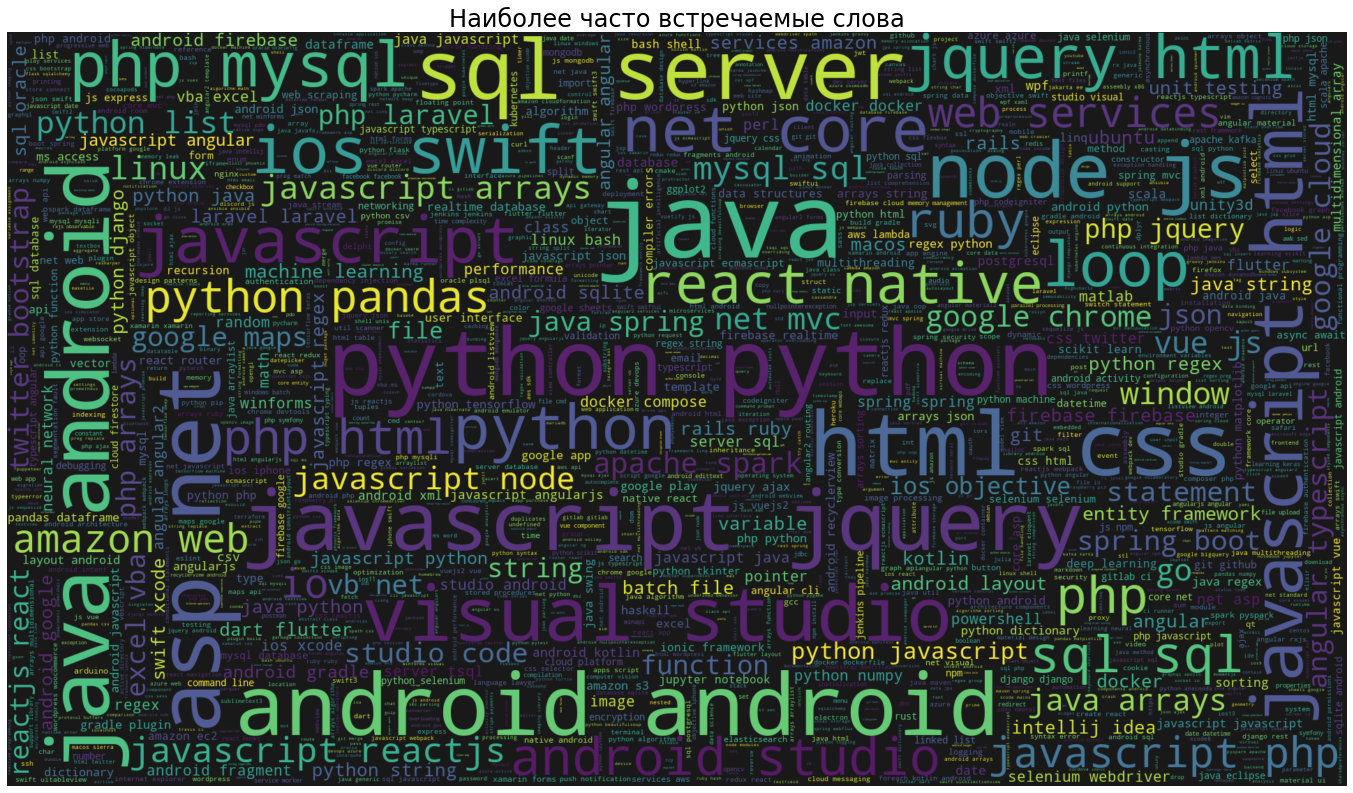

In [17]:
plt.figure(figsize=(24,24))
wc = WordCloud(background_color="black", max_words=1500, max_font_size=150,  width=1920, height=1080)
wc.generate(" ".join(techs))

plt.title("Наиболее часто встречаемые слова", fontsize=24)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=42), alpha=0.9, interpolation="bilinear", )
plt.axis('off')

if not os.path.exists(f"{OUTPUT_DIR_NAME}/tech_all.png"):
    plt.savefig(f"{OUTPUT_DIR_NAME}/tech_all.png")

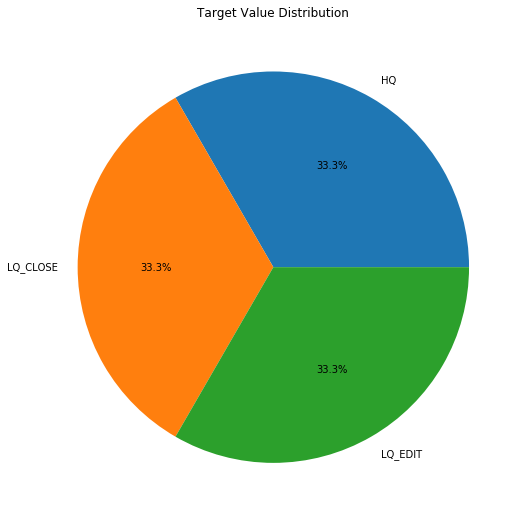

In [33]:
labels = ['HQ', 'LQ_CLOSE', 'LQ_EDIT']
values = [len(df[df['Y'] == 2]), len(df[df['Y'] == 0]), len(df[df['Y'] == 1])]
plt.figure(figsize=(16, 9))
plt.pie(x=values, labels=labels, autopct="%1.1f%%")
plt.title("Target Value Distribution")
plt.show()

In [19]:
df

,Title,Body,Tags,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat,0
1,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,sql sql-server,1
2,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,java optional,2
3,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,javascript image overlay react-native opa...,2
4,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",swift operators whitespace ternary-operato...,2
5,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,android material-design floating-action-but...,2
6,Accessing pointer member of the structure usin...,<p>I have defined integer pointer inside the s...,c pointers data-structures,0
7,"How To Disable 2nd Saturday 4th Saturday ,Sund...","i want to Disable 2nd Saturday 4th saturday,...",javascript jquery jquery-ui,1
8,Resizing containers in bootstrap,I am new to bootstrap and i would like to find...,jquery html css twitter-bootstrap,1
9,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,php mysql sql codeigniter mysqli,1


In [20]:
df['text'] = df['Title'] + ' ' + df['Body']
df = df.drop(['Title', 'Body'], axis=1)
df.head()

,Tags,Y,text
0,java repeat,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,sql sql-server,1,How to get all the child records from differen...
2,java optional,2,Why are Java Optionals immutable? <p>I'd like ...
3,javascript image overlay react-native opa...,2,Text Overlay Image with Darkened Opacity React...
4,swift operators whitespace ternary-operato...,2,Why ternary operator in swift is so picky? <p>...


In [21]:
df['text'] = df['text'].apply(preprocess)

In [44]:
df['text']

0        knockout click binding with parameters i'm try...
1        function of main() in c programming i am worki...
2        how to control knitr kable scientific notation...
3        how to split a string in java by a non printab...
4        plot three graphs in one i have three empirica...
5        what are the various join types in spark? i lo...
6        how to do insertion in if and else condition o...
7        hadoop installation error on running command f...
8        how do i read filenames from a folder and add ...
9        react render() is being called before componen...
10       tensorflow: loss decreasing, but accuracy stab...
11       checking to see if a string array index is emp...
12       create a temporary directory in powershell?  a...
13       what is promise in javascript? before posing t...
14       regex pattern 1,3,30,32,40-50,60 regex pattern...
15       pass interface between activities in intent - ...
16       parse error: syntax error, unexpected '!' i am.

In [22]:
df.head()

,Tags,Y,text
0,java repeat,0,java: repeat task every random seconds i'm alr...
1,sql sql-server,1,how to get all the child records from differen...
2,java optional,2,why are java optionals immutable? i'd like to ...
3,javascript image overlay react-native opa...,2,text overlay image with darkened opacity react...
4,swift operators whitespace ternary-operato...,2,why ternary operator in swift is so picky? the...


In [23]:
# Define how much percent data you wanna split
split_pcent = 0.20
split = int(split_pcent * len(df))

# Shuffles dataframe
df = df.sample(frac=1).reset_index(drop=True)

# Training Sets
train = df[split:]
trainX = train['text']
trainY = train['Y'].values

# Validation Sets
valid = df[:split]
validX = valid['text']
validY = valid['Y'].values

assert trainX.shape == trainY.shape
assert validX.shape == validY.shape

print(f"Training Data Shape: {validX.shape}\nValidation Data Shape: {validX.shape}")

Training Data Shape: (12000,)
Validation Data Shape: (12000,)


In [75]:
trainX

12000    how to create calendar event that comes with m...
12001    i am writing code in angularjs using html . in...
12002    alter table drop column failed because one or ...
12003    find "www." in a string in javascript i have t...
12004    is there a reason that .str.split() will not w...
12005    how to read appsettings.json in my _layout.cht...
12006    is there really no way to wait for a promise i...
12007    web interface for multiple programming languag...
12008    drawing a doughnut chart with columns inside t...
12009    easiest way to update textview or string from ...
12010    how to add clickable link inside sting in swif...
12011    handler of adduiinterruptionmonitor is not cal...
12012    chrome extension persistent i am trying to lea...
12013    how do i can catch an error in this program i ...
12014    navcontroller doesn't work in ionic 4 i'm inje...
12015    taskkill /pid not working in gitbash i'm tryin...
12016    recursion with pointers i trying to write a re.

# Модели

In [24]:
vectorizer = TfidfVectorizer()
trainX = vectorizer.fit_transform(trainX)
validX = vectorizer.transform(validX)

## Наивный баес

In [25]:
nb = MultinomialNB()
nb.fit(trainX, trainY)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
f"Accurary: {nb.score(validX, validY) * 100}%"

'Accurary: 66.11666666666667%'

## Логическая регрессия

In [27]:
lr = LogisticRegression()
lr.fit(trainX, trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
f"Accurary: {lr.score(validX, validY) * 100}%"

'Accurary: 74.09166666666667%'

## Дерево решений

In [29]:
dtc = DecisionTreeClassifier()
dtc.fit(trainX, trainY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [30]:
f"Accurary: {dtc.score(validX, validY)*100}%"

'Accurary: 61.33333333333333%'

## KNN

In [31]:
knc = KNeighborsClassifier(n_neighbors=7)
knc.fit(trainX, trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [32]:
f"Accurary: {knc.score(validX, validY)*100}%"

'Accurary: 58.72500000000001%'

In [1]:
# TODO:
#       Попробовать другую предобработку и другие параметры в моделях
#       Добавить еще 1-2 модели